# Cvičení 3: Optimalizace, metoda nejměnších čtverců a rozpoznávání not

V tomto cvičení si ukážeme malou ukázku optimalizačních úloh. Ukážeme si metodu nejmenších čtverců a její využití při rozpoznávání not.

---


Toto jsou knihovny a funkcionality, které budeme využívat:


In [1]:
from scipy import signal as sgn  # pro okenní Fourierovu transformaci
from scipy.io import wavfile  # pro čtení WAV souborů
from IPython.display import Audio  # pro přehrávání zvuků
import numpy as np  # lineární algebra
import matplotlib.pyplot as plt  # vykreslování grafů
from scipy.optimize import minimize  # numerická minimalizace funkce

## Část 1: Motivační Slovní Úloha: Optimalizace Cen a Výrobních Nákladů Limonády

Vlastníte stánek s limonádou a chcete optimalizovat cenu za sklenici, aby se maximalizoval váš zisk. Na základě vašich zkušeností jste zjistili, že počet prodaných limonád $ q $ v závislosti na ceně $ p $ (v korunách) lze aproximovat takto:
$$ q(p) = 1000 \exp\left(-\left(\frac{p}{10}\right)^2\right) $$

`Jedná se samozřejmě o spojitou aproximaci, v skutečnosti prodáváte celočíselný počet limonád, ale to v tuhle chvíli nebudeme řešit.`


In [2]:
p = np.linspace(0, 20, 200)
q = 1000 * np.exp(-(p / 10)**2)

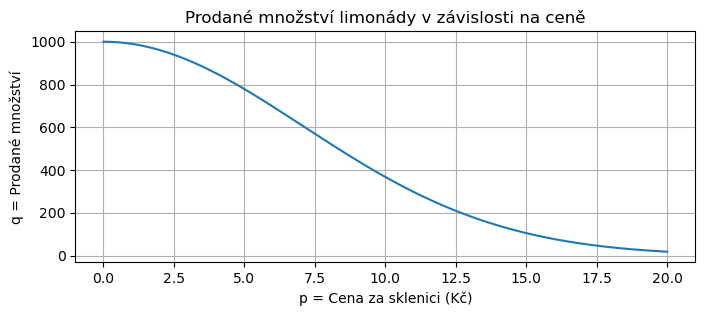

In [3]:
plt.figure(figsize=(8, 3))
plt.plot(p, q)
plt.xlabel('p = Cena za sklenici (Kč)')
plt.ylabel('q = Prodané množství')
plt.title('Prodané množství limonády v závislosti na ceně')
plt.grid(True)
plt.show()

Výrobní náklady na jednu sklenici limonády $ c $ závisí na množství vyrobeného množství $ q $ a jsou dány vztahem:
$$ c(q) = 5 + 15 \exp\left(-\frac{q}{200}\right) $$


In [4]:
q = np.arange(0, 1000)
c = 5 + 15 * np.exp(-q / 200)

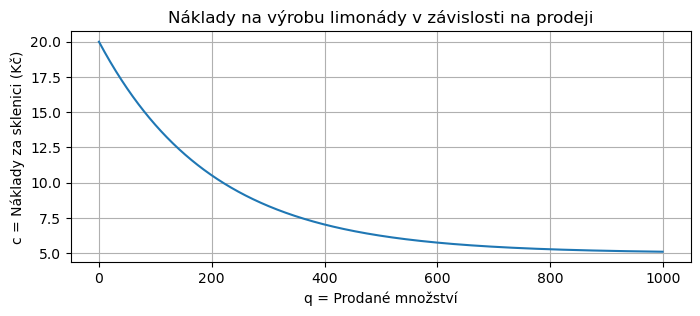

In [5]:
plt.figure(figsize=(8, 3))
plt.plot(q, c)
plt.xlabel('q = Prodané množství')
plt.ylabel('c = Náklady za sklenici (Kč)')
plt.title('Náklady na výrobu limonády v závislosti na prodeji')
plt.grid(True)
plt.show()

**`Cílem je nalézt optimální cenu za sklenici limonády tak, aby se maximalizoval celkový zisk.`**

#### Formulace Optimalizačního Problému

Zisk za sklenici $ z $ je rozdíl mezi cenou a výrobními náklady, tedy:
$$ z = p - c $$

tedy:
$$ z(p) = p - c(q(p)) $$

Celkový zisk $ t $ z prodeje limonády je součin zisku za sklenici a množství prodaných sklenic. Zde je třeba poznamenat, že předpokládáme, že všechny sklenice které vyrobíme, také prodáme, tedy:
$$ t(p) = z(p) q(p) $$

Dáme-li tyto vztahy dohromady, dostaneme:

$$ t(p) = \left( p - 5 - 15 \exp\left(-\frac{ 1000 \exp\left(-\left(\frac{p}{10}\right)^2\right) }{200}\right) \right) \left( 1000 \exp\left(-\left(\frac{p}{10}\right)^2\right) \right) $$

#### Řešení

Problém spočívá v nalezení hodnoty $ p $, která maximalizuje $ t $.

$$p^* = \argmax_{p \in \mathbb{R}} ~t(p)$$

Toto může vyžadovat použití numerických metod, maximalizovaná funkce je poměrně složitá.


**Zde se jedná o jednodimenzionální optimalizační problém, u kterého navíc víme, že řešení bude někde v intervalu $ [5, 20] $. Proto můžeme zkusit "vyřešit" vizuálně.**


### Úkol 1: Vykreslete funkci $ t(p) $ v intervalu $ [5, 20] $.

In [6]:
p = np.linspace(5, 20, 1000)
q = 1000 * np.exp(-(p / 10)**2)
c = 5 + 15 * np.exp(-q / 200)
z = p - c
t = z * q

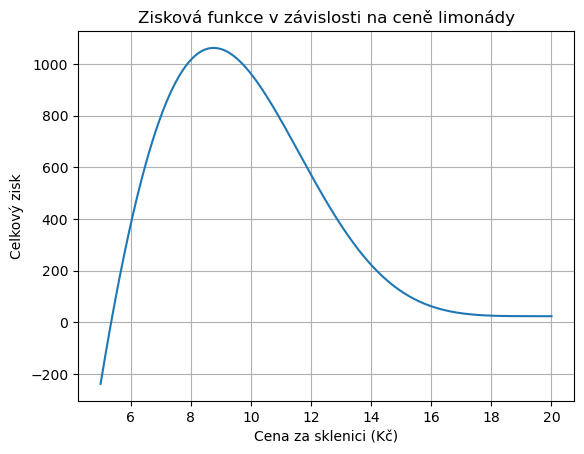

In [7]:
plt.plot(p, t)
plt.xlabel('Cena za sklenici (Kč)')
plt.ylabel('Celkový zisk')
plt.title('Zisková funkce v závislosti na ceně limonády')
plt.grid(True)
plt.show()

Pro numerické řešení můžeme použít knihovnu `scipy.optimize` a její funkci `minimize`. Tato funkce umí minimalizovat funkce s jednou nebo více proměnnými. V našem případě je třeba funkci maximalizovat, proto je třeba ji předat jako funkci, která vrací opačnou hodnotu.

Funkce `minimize` má mnoho parametrů, a má implementováno mnoho numerických metod pro minimalizaci. My použijeme její výchozí nastavení, typ metody tedy nebude specifikován. Parametry, které musíme specifikovat jsou:

- `fun`: funkce, kterou chceme minimalizovat, musí to být funkce s jedním vstupem (může být vektor) a jedním výstupem (musí být skalár=číslo)
- `x0`: počáteční bod, ze kterého se bude hledat minimum (musí být možné předat funkci `fun`)


### Úkol 2: Nalezněte optimální cenu za sklenici limonády.
- napište funkci `zisk(p)`, která vrací celkový ziskpro cenu `p` za sklenici
- použijte funkci `minimize` pro nalezení optimální ceny
    - jako `fun` použijte funkci `zisk`
    - jako `x0` použijte nějakou hodnotu z intervalu $ [5, 20] $

In [8]:
def zisk(p):
    q = 1000 * np.exp(-(p / 10)**2)
    c = 5 + 15 * np.exp(-q / 200)
    z = p - c
    t = z * q
    return -t  # minus protože minimize umí hledat minimum


spektra_not = minimize(fun=zisk, x0=10)
spektra_not

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -1061.9660311572484
        x: [ 8.761e+00]
      nit: 6
      jac: [ 0.000e+00]
 hess_inv: [[ 6.640e-03]]
     nfev: 14
     njev: 7

Sedí váš výsledek s grafem funkce $ t(p) $?

## Část 2: Metoda nejmenších čtverců a určování zahraných not


### Získání amplitudových spekter not

- ve složce `notes` jsou uloženy zvukové soubory jednotlivých not jak jdou po klapkách na klavíru: `t1.wav`, ..., `t88.wav`
- postupně všechny načteme, znormalizujeme signál a vypočteme amplitudové spektrum pro prvních 0.1 sekundy nahrávky
  - toto děláme především proto, abychom nemuseli upravovat výsledná spektra = zvolíme stejnou délku signálu/okna pro všechny nahrávky

**Toto prolétneme velmi rychle, neboť jsme si vše již ukázali v minulém cvičení.**

In [347]:
spektra_not = []
trvani = 1/4

for j in range(1, 89):
    cesta_k_souboru = f"notes/t{j}.wav"  # cesta k souboru
    vzorkovaci_frekvence, signal = wavfile.read(cesta_k_souboru)

    velikost_okna = int(trvani * vzorkovaci_frekvence)
    signal = signal / np.max(np.abs(signal))  # normalizace signálu na [-1, 1]
    signal = signal[:velikost_okna]  # vyřízneme signál ze začátku

    normalizace = 1 / vzorkovaci_frekvence  # normalizace na integrál

    amplitudove_spektrum = np.abs(np.fft.rfft(signal) * 2 * normalizace / trvani)

    spektra_not.append(amplitudove_spektrum)

spektogram_not = np.vstack(spektra_not).T  # převedeme na matici a transponujeme = checme noty ve sloupcích

Zobrazíme výsledná amplitudová spektra not:


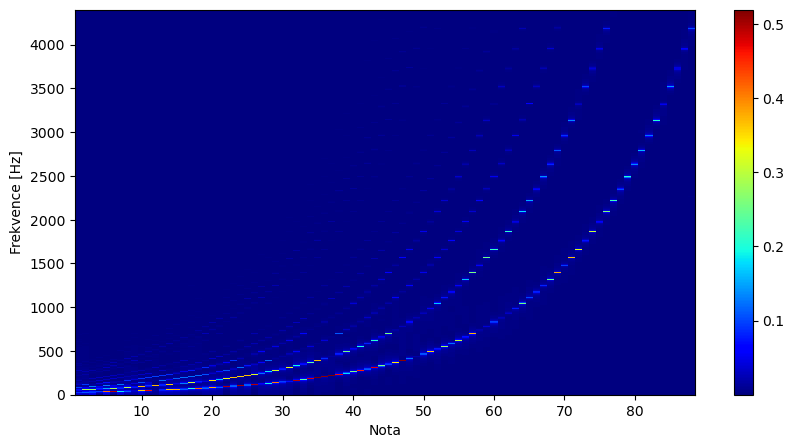

In [348]:
x_axis = np.arange(1, 89)  # x-ová osa = noty
y_axis = np.fft.rfftfreq(velikost_okna, 1 / vzorkovaci_frekvence)  # y-ová osa = frekvence

plt.figure(figsize=(10, 5))
plt.pcolormesh(x_axis, y_axis, spektogram_not, cmap='jet')
plt.xlabel('Nota')
plt.ylabel('Frekvence [Hz]')
plt.ylim(0, 4400)  # ořízneme vyšší frekvence
plt.colorbar()
plt.show()

**Proč to vypadá takto škaredě?**

- jednotlivé noty nemají celočíselné frekvence (což je to co počítáme)
- základní frekvence not klavíru se dají zapsat jako: $$ f_n = 440 \cdot 2^{\frac{n-49}{12}} $$
- tedy pěkné ostrý (nerozmazaný) spektrogram, získáme pouze pro některé noty, jiné budou mít amplitudové spektrum rozostřené


#### Mapování z tónů na na amplitudová spektra

- označíme si matici $A$ jako matici která bude tóny mapovat na amplitudová spektra
- tedy budu-li mít vektor $x$ o délce 88, kde na pozici $i$ bude 1, pak $Ax$ bude amplitudové spektrum noty $i$


**Jak vypadá spektrgram akordu C major?**

In [349]:
A = spektogram_not

x = np.zeros(88)
x[39] = 1  # C4
x[43] = 1  # E4
x[47] = 1  # G4

spektrum_Cmajor = A @ x

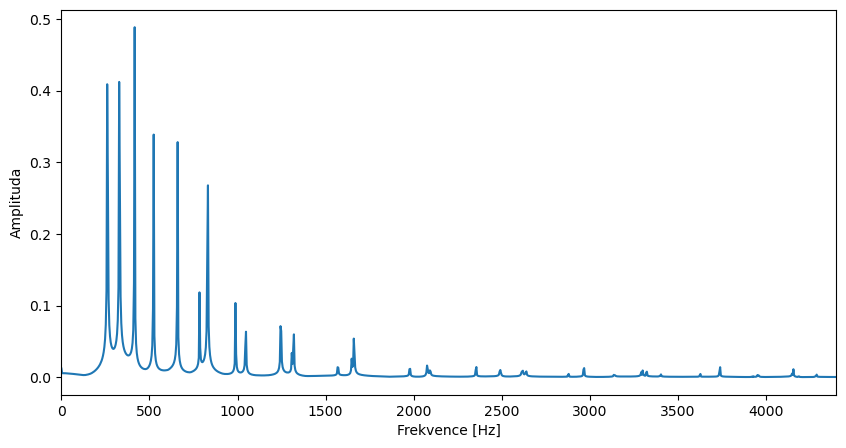

In [350]:
plt.figure(figsize=(10, 5))
plt.plot(y_axis, spektrum_Cmajor)  # jakožto osu x použijeme frekvence
plt.xlabel('Frekvence [Hz]')
plt.ylabel('Amplituda')
plt.xlim(0, 4400)
plt.show()

### Načteme vzorovou nahrávku pro určení not a spočítáme její amplitudové spektrum (časově frekvenční spektrogram)


In [351]:
vzorkovaci_frekvence, signal = wavfile.read('lune1.wav')
signal = signal / np.max(np.abs(signal))

In [352]:
Audio(signal, rate=vzorkovaci_frekvence)

In [355]:
delka_nahravky = len(signal) / vzorkovaci_frekvence
delka_okna_sekundy = trvani  # dékla okna musí souhlasit s délkou při zpracování spektrogramu pro noty
posun_okna_sekundy = trvani/5  # začneme bez překrytí

velikost_okna = int(delka_okna_sekundy * vzorkovaci_frekvence)
posun_okna = int(posun_okna_sekundy * vzorkovaci_frekvence)

# výpočet spektrogramu
y_axis, x_axis, casove_frekvencni_matice = sgn.spectrogram(signal,
                                                           fs=vzorkovaci_frekvence,
                                                           window='boxcar',
                                                           nperseg=velikost_okna,
                                                           noverlap=velikost_okna - posun_okna,
                                                           scaling='spectrum',  # přeškálování barev
                                                           mode='magnitude')  # amplituda

casove_frekvencni_matice = 2 * casove_frekvencni_matice  # korekce amplitudy

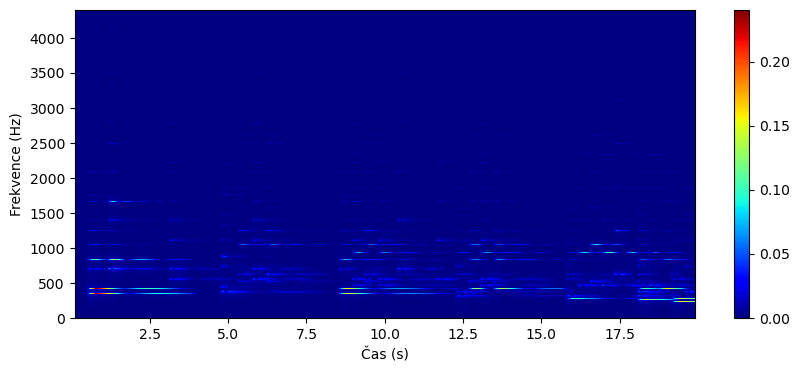

In [356]:

plt.figure(figsize=(10, 4))
plt.pcolormesh(x_axis, y_axis, casove_frekvencni_matice, cmap='jet')
plt.colorbar()
plt.xlabel('Čas (s)')
plt.ylabel('Frekvence (Hz)')

plt.ylim(0, 4400)

plt.show()

### Inverzní úloha a nejmenší čtverce

Už jsme si ukázali, jak získat amplitudová spektra pokud víme jaké noty jsou zahrané. Nyní se podíváme na inverzní úlohu, tedy jak z amplitudových spekter určit, které noty jsou zahrané.

Tedy pro každé časové okno $i$ spektrogramu budeme hledat vektor $x_i$, který (v ideálním případě) bude po přenásobení maticí $A$ dávat amplitudové spektrum tohoto okna ($y_i$): $$ A x_i = y_i $$

Toto ale bohužel nejde, rovnost v rovnici nemusí platit přesně. Stačí aby jedna z nahrávek byla nahrána s minumálním šumem a rovnosti se nebude dát dosáhnout.

Proto místo hledání přesné rovnosti se můžeme omezit na hledání nejpřesnější aproximace. Chybu aproximace not $x_i$ v amplitudovém spektru můžeme vyjádřit jako: $$ e_i = A x_i - y_i $$

Nyní chceme takové $x_i$, které minimalizuje chybu aproximace, tedy aby chyba skrze celé spetrum byla co možná nejmenší.

Zde do hry vstupuje tzv. `metoda nejmenších čtverců`. Ta říká, že chybu aproximace skrze celý vektor $e_i$ můžeme vyjádřit jakou součet čtverců chyb jednotlivých složek vektoru $e_i$. Tedy funkce (nyní jdoucí do $\mathbb{R}$) určující chybu aproximace $x$ může být vyjádřena jako: $$ f(x) = \sum_{j}\left[ A x - y_i\right]_j^2 $$

A příslušná identifikace not v časovém okně $i$ je tedy: 
$$ x_i^{*} = \argmin_{x \in \mathbb{R}^{88}} \sum_{j}\left[ A x - y_i\right]_j^2 $$


In [357]:
i = 100
y_i = casove_frekvencni_matice[:, i]


def chyba(x):
    e = A @ x - y_i
    f_e = np.sum(e**2)
    return f_e


x0 = np.zeros(88)

res_1 = minimize(fun=chyba, x0=x0)
res_1

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.0007764253245580299
        x: [-4.770e-02  5.849e-02 ... -3.139e-03 -2.578e-03]
      nit: 74
      jac: [-1.613e-06  5.053e-06 ...  5.814e-06  3.221e-07]
 hess_inv: [[ 1.244e+02 -1.573e+02 ...  2.060e+00 -1.123e+00]
            [-1.573e+02  2.052e+02 ... -2.415e+00  1.461e+00]
            ...
            [ 2.060e+00 -2.415e+00 ...  1.978e+00  1.800e-01]
            [-1.123e+00  1.461e+00 ...  1.800e-01  1.706e+00]]
     nfev: 6942
     njev: 78

In [358]:
def chyba_grad(x):
    e = A @ x - y_i
    grad = 2 * A.T @ e
    return grad

In [359]:

res_1 = minimize(fun=chyba, x0=x0, jac=chyba_grad)
res_1

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.0007764253246495035
        x: [-4.770e-02  5.849e-02 ... -3.139e-03 -2.578e-03]
      nit: 74
      jac: [-1.613e-06  5.053e-06 ...  5.814e-06  3.221e-07]
 hess_inv: [[ 1.244e+02 -1.573e+02 ...  2.060e+00 -1.123e+00]
            [-1.573e+02  2.052e+02 ... -2.415e+00  1.461e+00]
            ...
            [ 2.060e+00 -2.415e+00 ...  1.978e+00  1.800e-01]
            [-1.123e+00  1.461e+00 ...  1.800e-01  1.706e+00]]
     nfev: 78
     njev: 78

<function matplotlib.pyplot.show(close=None, block=None)>

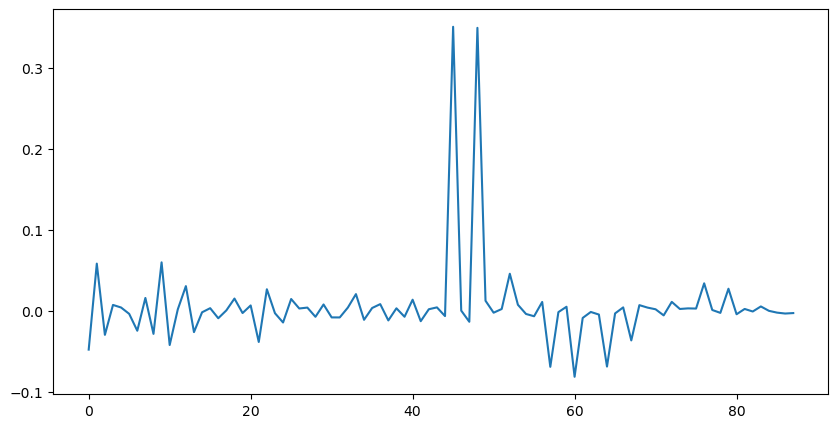

In [360]:
plt.figure(figsize=(10, 5))
plt.plot(res_1.x)
plt.show

### Co to je? Tohle jsme určitě nechtěli!

- minimalizace funkce $f$ hledá libovolný vektor $x \in \mathbb{R}^{88}$, který minimalizuje $f$
- tedy, pokud "mix" kladných a záporných hodnot dostane lepší výsledek, tak pak bude řešením!!!


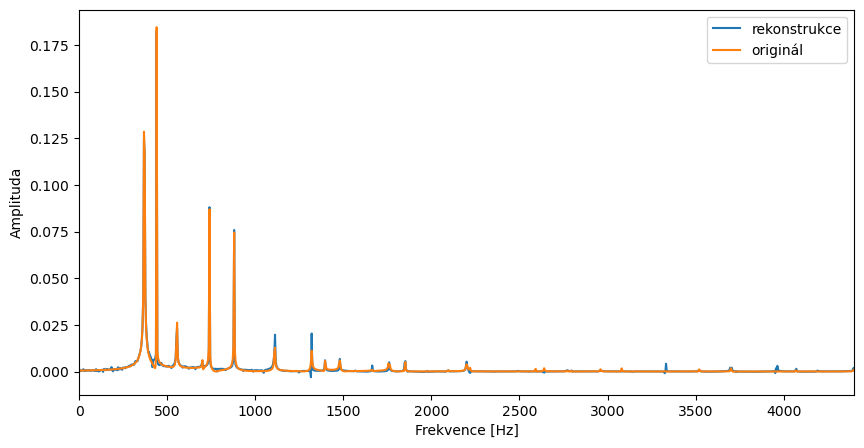

In [361]:
plt.figure(figsize=(10, 5))
plt.plot(y_axis, A @ res_1.x, label='rekonstrukce')
plt.plot(y_axis, y_i, label='originál')
plt.legend()
plt.xlabel('Frekvence [Hz]')
plt.ylabel('Amplituda')
plt.xlim(0, 4400)
plt.show()

### Omezení pouze na kladné hodnoty
Pro identifikaci not nás ale zajímají pouze kladné "výskyty" not. Tedy chceme, aby vektor $x$ obsahoval pouze kladné hodnoty. 

Tedy ve skutečnosti chceme řešit minimalizaci s omezením: $$ x_i^* = \argmin_{x \in \mathbb{R}^{88},~~x_i \geq 0} ~~~\sum_{j}\left[ A x - y_i\right]_j^2$$

Naštěstí funkce `minimize` umí i minimalizace s omezením, stačí jí zadat parameter:
- `bounds`: seznam dvojic, kde každá dvojice určuje dolní a horní mez pro danou proměnnou
    - my nebudeme chtít žádné horní meze, tedy všechny budou mít horní mez `None`

In [362]:
bounds = []
for i in range(88):
    bounds.append((0, None))

In [363]:
res_2 = minimize(fun=chyba, x0=x0, bounds=bounds, jac=chyba_grad)
res_2

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.004178786949981473
        x: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
      nit: 13
      jac: [ 2.456e-03  2.564e-03 ...  1.667e-03  5.984e-04]
     nfev: 15
     njev: 15
 hess_inv: <88x88 LbfgsInvHessProduct with dtype=float64>

<function matplotlib.pyplot.show(close=None, block=None)>

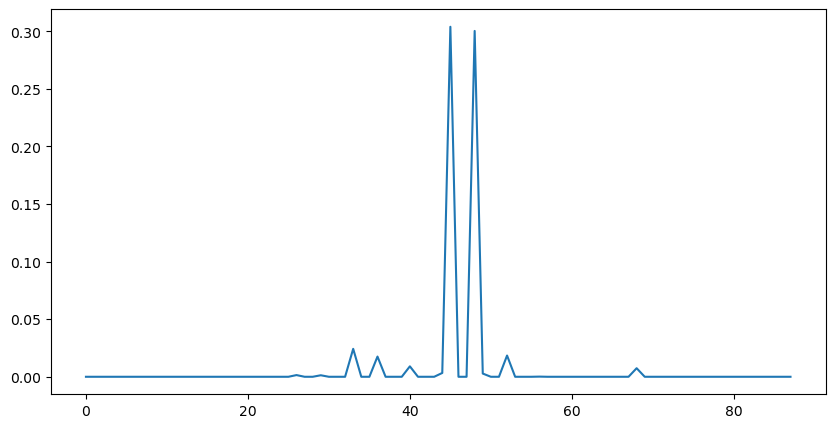

In [364]:
plt.figure(figsize=(10, 5))
plt.plot(res_2.x)
plt.show

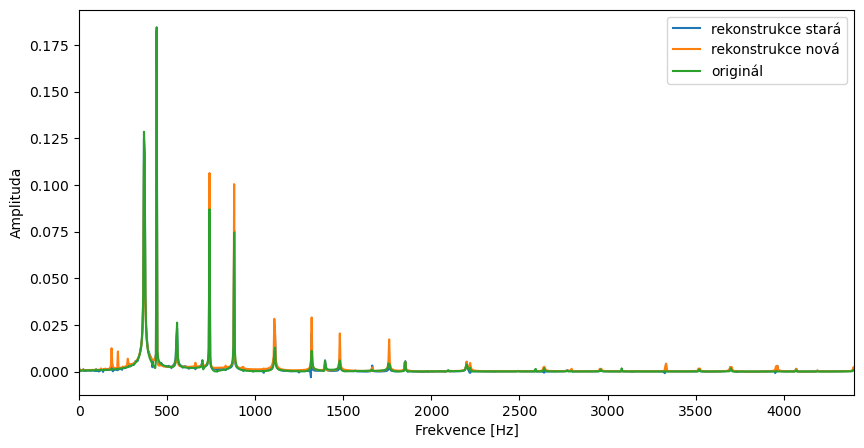

In [365]:
plt.figure(figsize=(10, 5))
plt.plot(y_axis, A @ res_1.x, label='rekonstrukce stará')
plt.plot(y_axis, A @ res_2.x, label='rekonstrukce nová')
plt.plot(y_axis, y_i, label='originál')
plt.legend()
plt.xlabel('Frekvence [Hz]')
plt.ylabel('Amplituda')
plt.xlim(0, 4400)
plt.show()

### A nyní pro všechna časová okna!


In [366]:
pocet_oken = casove_frekvencni_matice.shape[1]

noty_v_case = np.zeros((88, pocet_oken))

for i in range(pocet_oken):
    y_i = casove_frekvencni_matice[:, i]

    res_1 = minimize(fun=chyba, x0=x0, bounds=bounds, jac=chyba_grad)
    noty_v_case[:, i] = res_1.x

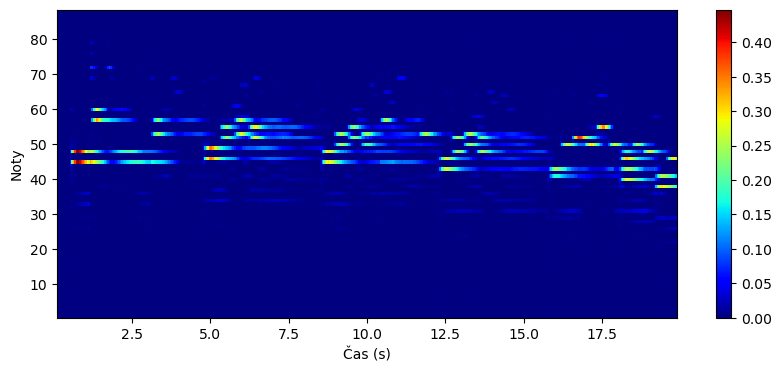

In [370]:
plt.figure(figsize=(10, 4))
plt.pcolormesh(x_axis, range(1, 89), noty_v_case, cmap='jet')
plt.colorbar()
plt.xlabel('Čas (s)')
plt.ylabel('Noty')
plt.show()

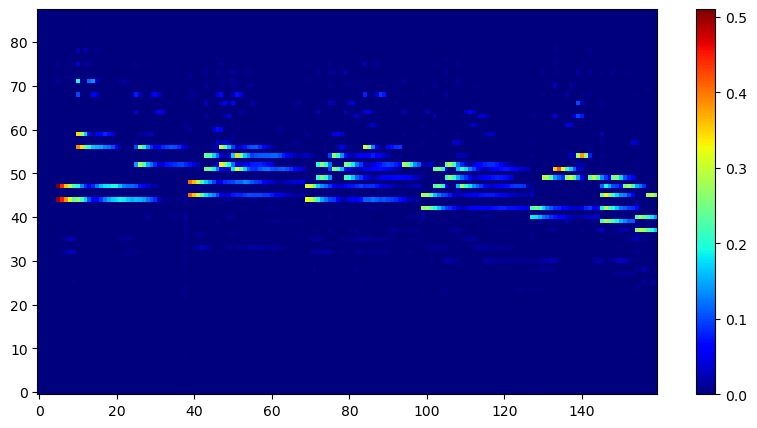

In [282]:
plt.figure(figsize=(10, 5))
plt.imshow(noty_v_case, cmap='jet', aspect='auto', origin='lower')
plt.colorbar()
plt.show()

In [18]:
casove_frekvencni_matice.shape

(2206, 200)

In [19]:
from scipy.optimize import minimize

solutions3 = np.zeros_like(solutions)
A = minsq_mat  # Replace with your A matrix

bounds = [(0, None) for _ in range(A.shape[0])]
# Objective function
min_sqr_last = 1

last_notes = np.ones((88, ), dtype=bool)
for j in range(solutions.shape[1]):
    print(f"Iteration {j+1} of {solutions.shape[1]}.")
    x0 = noty_v_case[:, j]
    x0[x0 < 0.1] = 1e-6
    b = rhs[:, j]    # Replace with your b vector

    def objective(x):
        residual = (mat @ x - casove_frekvencni_matice[:, j])
        res_sq = np.dot(residual.T, residual)
        penalta = residuals[j] * 0.2 * np.sum(np.tanh(1e3 * x[last_notes]))
        return res_sq + penalta

    res_min = minimize(objective, x0, bounds=bounds)
    tmp = res_min.x
    last_notes = tmp < 0.01
    print(f"Residual: {res_min.fun:.2f}")
    solutions3[:, j] = tmp
    min_sqr_last = 0.5 * np.dot(tmp.T, np.dot(A, tmp)) - np.dot(b.T, tmp) + np.dot(b.T, b)

Iteration 1 of 200.
Residual: 0.00
Iteration 2 of 200.
Residual: 0.00
Iteration 3 of 200.
Residual: 0.00
Iteration 4 of 200.
Residual: 0.00
Iteration 5 of 200.
Residual: 0.00
Iteration 6 of 200.
Residual: 0.00
Iteration 7 of 200.
Residual: 0.01
Iteration 8 of 200.
Residual: 0.00
Iteration 9 of 200.
Residual: 0.00
Iteration 10 of 200.
Residual: 0.00
Iteration 11 of 200.
Residual: 0.00
Iteration 12 of 200.
Residual: 0.00
Iteration 13 of 200.
Residual: 0.01
Iteration 14 of 200.
Residual: 0.00
Iteration 15 of 200.
Residual: 0.00
Iteration 16 of 200.
Residual: 0.00
Iteration 17 of 200.
Residual: 0.00
Iteration 18 of 200.
Residual: 0.00
Iteration 19 of 200.
Residual: 0.00
Iteration 20 of 200.
Residual: 0.00
Iteration 21 of 200.
Residual: 0.00
Iteration 22 of 200.
Residual: 0.00
Iteration 23 of 200.
Residual: 0.00
Iteration 24 of 200.
Residual: 0.00
Iteration 25 of 200.
Residual: 0.00
Iteration 26 of 200.
Residual: 0.00
Iteration 27 of 200.
Residual: 0.00
Iteration 28 of 200.
Residual: 0.00
I

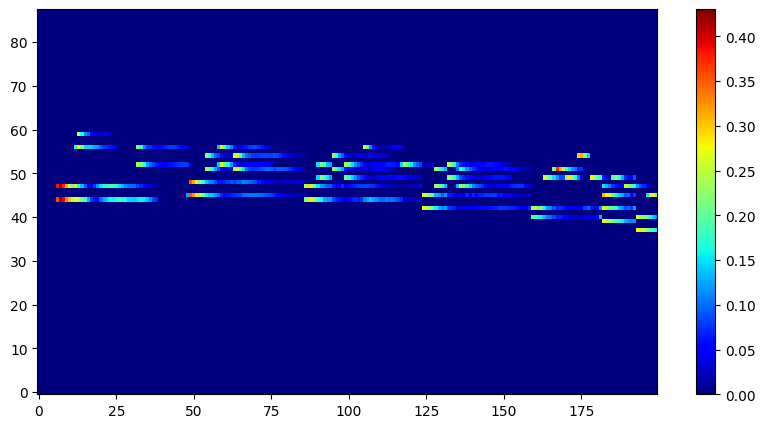

In [20]:
plt.figure(figsize=(10, 5))
plt.imshow(solutions3, cmap='jet', aspect='auto', origin='lower', interpolation='none')
plt.colorbar()
plt.show()

In [1]:
import jax